In [1]:
import pathlib
import imageio
import numpy as np

training_paths = pathlib.Path('D:/downloads/data-science-bowl-2018/stage1_train').glob("*/images/*.png")
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

In [2]:
print("Original image shape: {}".format(im.shape))

from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print("New image shape: {}".format(im_gray.shape))

Original image shape: (520, 696, 4)
New image shape: (520, 696)


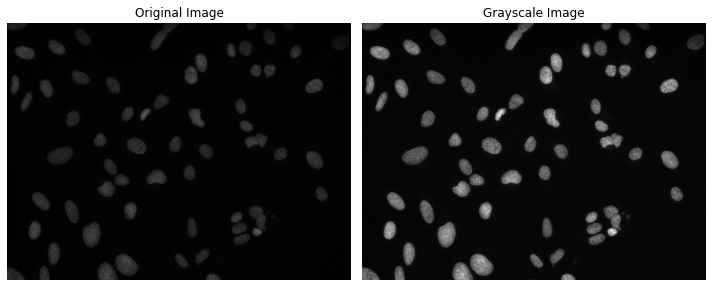

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

In [30]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

0.08195465686274508


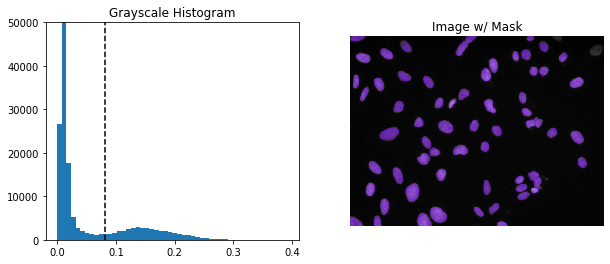

In [11]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels, bins = 50)
plt.vlines(thresh_val, 0, 100000, linestyle="--")
plt.ylim([0, 50000])
plt.title("Grayscale Histogram")

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

In [37]:
len(ndimage.label(mask)[0])

520

im_gray는 픽셀들이 쭉 늘어진 형태의 데이터(한 장의 이미지)

In [16]:
from scipy import ndimage
# labels = 어떤 label(1-76까지)이 어디 있는지(np.zeros+label위치)
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


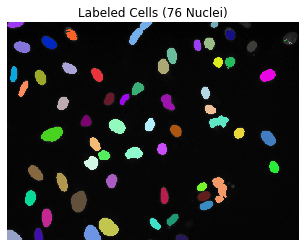

In [17]:
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256, 3))

labels_for_display = np.where(labels > 0, labels, np.nan) # label이 있는 곳만 보이고 나머지는 nan으로 바꾼다.
plt.imshow(im_gray, cmap='gray') # grayscale된 이미지를 띄우고
plt.imshow(labels_for_display, cmap=rand_cmap)  # 마스크로 덮어 색으로 나타낸다.
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

In [49]:
len(ndimage.find_objects(labels))
im_gray[(slice(0, 14, None), slice(1, 40, None))].shape

(14, 39)

In [25]:
# find_objects returns a list of the coordinate range for each labeled object in your image.
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # The default, axis=None, will calculate the product of all the elements in the input array. 
    # Check if the label size is too small
    # cell.shape는 마스크(label)이 차지한 픽셀의 가로 세로 np.product로 곱하면 그 픽셀들의 크기
    # 너무 작으면 0으로 만들자
    if np.product(cell.shape) < 10:
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

labels, nlabels = ndimage.label(mask)

# 너무 작은 크기를 갖고 있는 마스크들
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detected.


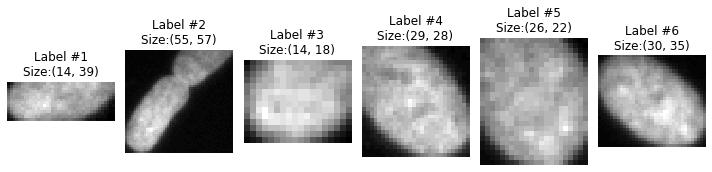

In [51]:
fig, axes = plt.subplots(1,6, figsize=(10, 6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    # label cell이 있는 좌표를 넣어줘서 
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize:{}'.format(ii+1, cell.shape))
    
plt.tight_layout()
plt.show()

### mask erosion

In [57]:
# 세포가 두 개 붙어있는 레이블의 좌표를 리턴, 두 번째 레이블이었으까 1
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
# binary opening - erosion + dilation
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

In [62]:
cell_mask_opened.shape

(55, 57)

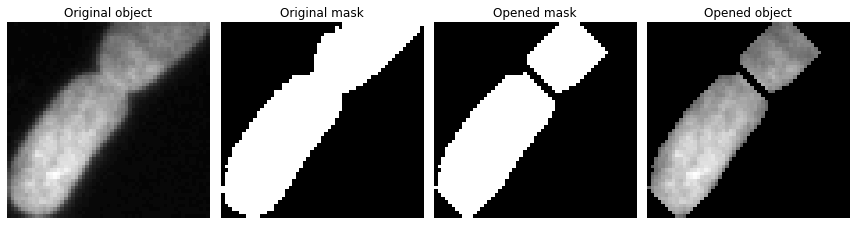

In [67]:
fig, axes = plt.subplots(1, 4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title("Original object")
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title("Original mask")
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title("Opened mask")
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title("Opened object")

for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [73]:
def rle_encoding(x):
    """
    x : numpy array of shape(height, width), 1 - mask, 0 - background
    Returns run length as list
    """
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print("RLE Encoding for the current mask is: {}".format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


In [71]:
np.where(label_mask.T.flatten()==1)

(array([210074, 210075, 210076, 210077, 210078, 210079, 210592, 210593,
        210594, 210595, 210596, 210597, 210598, 210599, 211111, 211112,
        211113, 211114, 211115, 211116, 211117, 211118, 211119, 211630,
        211631, 211632, 211633, 211634, 211635, 211636, 211637, 211638,
        211639, 212149, 212150, 212151, 212152, 212153, 212154, 212155,
        212156, 212157, 212158, 212159, 212668, 212669, 212670, 212671,
        212672, 212673, 212674, 212675, 212676, 212677, 212678, 212679,
        213188, 213189, 213190, 213191, 213192, 213193, 213194, 213195,
        213196, 213197, 213198, 213199, 213708, 213709, 213710, 213711,
        213712, 213713, 213714, 213715, 213716, 213717, 213718, 213719,
        214227, 214228, 214229, 214230, 214231, 214232, 214233, 214234,
        214235, 214236, 214237, 214238, 214239, 214747, 214748, 214749,
        214750, 214751, 214752, 214753, 214754, 214755, 214756, 214757,
        214758, 214759, 215267, 215268, 215269, 215270, 215271, 